In [17]:
!pip install -U insightface onnxruntime opencv-python-headless numpy tqdm

In [18]:
import insightface
from insightface.app import FaceAnalysis
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load ArcFace model
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:07<00:00, 40084.31KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [19]:
from sklearn.metrics.pairwise import cosine_similarity

def get_face_embedding(image_path):
    """Extracts face embedding from an image."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faces = app.get(img)
    if faces:
        return faces[0].normed_embedding  # Return first detected face's embedding
    return None

def get_faces_from_group(image_path):
    """Extracts all faces and embeddings from a group photo."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faces = app.get(img)
    face_data = []

    for face in faces:
        bbox = face.bbox.astype(int)  # Face bounding box
        embedding = face.normed_embedding  # 512-D embedding
        face_data.append((bbox, embedding))

    return img, face_data

In [23]:
def match_faces(person_image, group_image):
    """Finds, highlights, and displays matched faces separately."""
    person_embedding = get_face_embedding(person_image)
    if person_embedding is None:
        print("No face detected in the person's image.")
        return

    img, group_faces = get_faces_from_group(group_image)
    if not group_faces:
        print("No faces detected in the group image.")
        return

    matched_faces = []
    for bbox, emb in group_faces:
        similarity = cosine_similarity([person_embedding], [emb])[0][0]
        if similarity > 0.5:  # Set a similarity threshold
            matched_faces.append(bbox)

    if not matched_faces:
        print("No matching faces found.")
        return

    # Show the detected person separately
    plt.figure(figsize=(12, 6))
    plt.subplot(1, len(matched_faces) + 1, 1)  # First subplot for person's image
    person_img = cv2.imread(person_image)
    person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)
    plt.imshow(person_img)
    plt.title("Person to Find")
    plt.axis("off")

    # Draw bounding boxes and extract matched faces
    for i, bbox in enumerate(matched_faces, start=2):  # Start from subplot 2
        x1, y1, x2, y2 = bbox
        face_img = img[y1:y2, x1:x2]  # Crop face from group photo

        # Draw bounding box on the original image
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

        # Show detected face separately
        plt.subplot(1, len(matched_faces) + 1, i)
        plt.imshow(face_img)
        plt.title(f"Match {i-1}")
        plt.axis("off")

    plt.show()

    # Show the final group image with bounding boxes
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title("Matched Faces in Group Photo")
    plt.axis("off")
    plt.show()

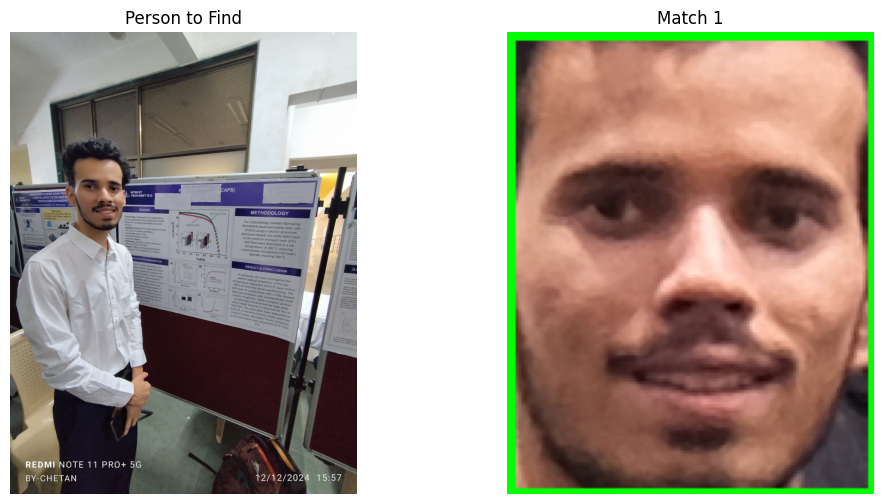

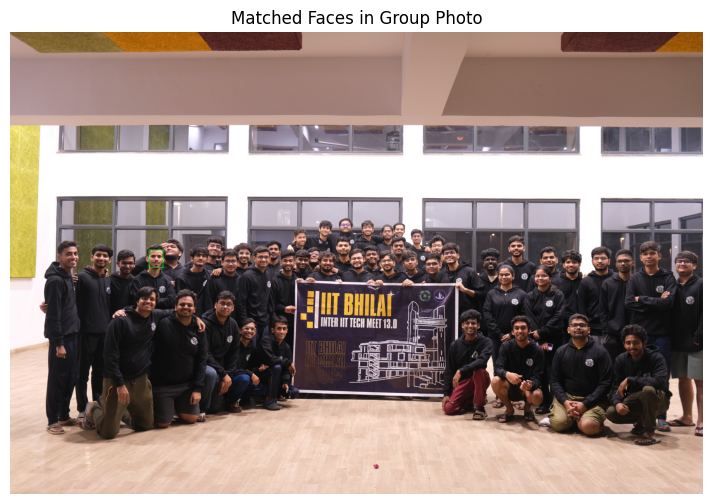

In [30]:
person_img = "/content/img6.jpeg"  # Change to your person image path
group_img = "/content/DSCF3076 (1).JPG"   # Change to your group image path

match_faces(person_img, group_img)